In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('FPT.csv')

data

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2020 14:24,58.20,58.20,58.20,58.20,27470,0
97402,FPT,12/22/2020 14:25,58.20,58.20,58.20,58.20,14820,0
97403,FPT,12/22/2020 14:26,58.20,58.20,58.20,58.20,500,0
97404,FPT,12/22/2020 14:29,58.10,58.10,58.10,58.10,2500,0


In [2]:
data = data[['Date/Time', 'Close']]
data

,Date/Time,Close
0,12/25/2018 9:15,30.89
1,12/25/2018 9:16,30.81
2,12/25/2018 9:17,30.74
3,12/25/2018 9:18,30.74
4,12/25/2018 9:19,30.74
...,...,...
97401,12/22/2020 14:24,58.20
97402,12/22/2020 14:25,58.20
97403,12/22/2020 14:26,58.20
97404,12/22/2020 14:29,58.10


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

/tmp/ipykernel_69130/4152136917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date/Time'] = pd.to_datetime(data['Date/Time'])


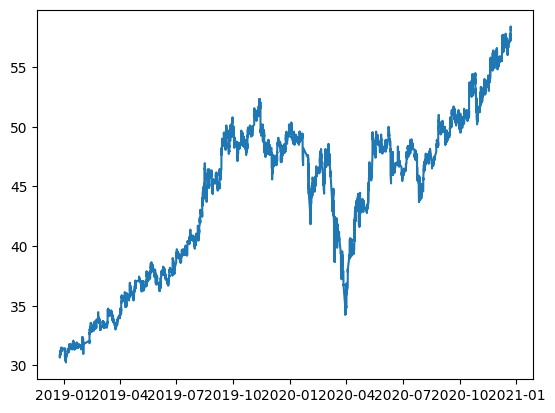

In [4]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'])

plt.plot(data['Date/Time'], data['Close'])

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date/Time', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 30
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-21),Close(t-22),Close(t-23),Close(t-24),Close(t-25),Close(t-26),Close(t-27),Close(t-28),Close(t-29),Close(t-30)
Date/Time,,,,,,,,,,,,,,,,,,,,,
2018-12-26 09:53:00,30.96,30.89,30.89,30.96,30.89,30.89,30.96,30.96,30.96,30.96,...,31.19,31.19,31.11,30.66,30.74,30.74,30.74,30.74,30.81,30.89
2018-12-26 09:55:00,30.96,30.96,30.89,30.89,30.96,30.89,30.89,30.96,30.96,30.96,...,31.15,31.19,31.19,31.11,30.66,30.74,30.74,30.74,30.74,30.81
2018-12-26 09:56:00,31.04,30.96,30.96,30.89,30.89,30.96,30.89,30.89,30.96,30.96,...,31.11,31.15,31.19,31.19,31.11,30.66,30.74,30.74,30.74,30.74
2018-12-26 09:57:00,31.19,31.04,30.96,30.96,30.89,30.89,30.96,30.89,30.89,30.96,...,31.11,31.11,31.15,31.19,31.19,31.11,30.66,30.74,30.74,30.74
2018-12-26 09:59:00,31.11,31.19,31.04,30.96,30.96,30.89,30.89,30.96,30.89,30.89,...,31.11,31.11,31.11,31.15,31.19,31.19,31.11,30.66,30.74,30.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22 14:24:00,58.20,58.20,58.10,58.10,58.10,58.10,58.10,58.10,58.10,58.10,...,58.40,58.20,58.10,58.00,58.00,58.00,57.90,57.80,57.90,57.90
2020-12-22 14:25:00,58.20,58.20,58.20,58.10,58.10,58.10,58.10,58.10,58.10,58.10,...,58.40,58.40,58.20,58.10,58.00,58.00,58.00,57.90,57.80,57.90
2020-12-22 14:26:00,58.20,58.20,58.20,58.20,58.10,58.10,58.10,58.10,58.10,58.10,...,58.30,58.40,58.40,58.20,58.10,58.00,58.00,58.00,57.90,57.80


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[30.96, 30.89, 30.89, ..., 30.74, 30.81, 30.89],
       [30.96, 30.96, 30.89, ..., 30.74, 30.74, 30.81],
       [31.04, 30.96, 30.96, ..., 30.74, 30.74, 30.74],
       ...,
       [58.2 , 58.2 , 58.2 , ..., 58.  , 57.9 , 57.8 ],
       [58.1 , 58.2 , 58.2 , ..., 58.  , 58.  , 57.9 ],
       [58.1 , 58.1 , 58.2 , ..., 58.  , 58.  , 58.  ]])

In [7]:
shifted_df_as_np.shape

(97376, 31)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.94955595, -0.95452931, -0.95452931, ..., -0.96468468,
        -0.95963964, -0.95387387],
       [-0.94955595, -0.94955595, -0.95452931, ..., -0.96468468,
        -0.96468468, -0.95963964],
       [-0.94387211, -0.94955595, -0.94955595, ..., -0.96468468,
        -0.96468468, -0.96468468],
       ...,
       [ 0.98579041,  0.98579041,  0.98579041, ...,  1.        ,
         0.99279279,  0.98558559],
       [ 0.97868561,  0.98579041,  0.98579041, ...,  1.        ,
         1.        ,  0.99279279],
       [ 0.97868561,  0.97868561,  0.98579041, ...,  1.        ,
         1.        ,  1.        ]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((97376, 30), (97376,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.95387387, -0.95963964, -0.96468468, ..., -0.94955595,
        -0.95452931, -0.95452931],
       [-0.95963964, -0.96468468, -0.96468468, ..., -0.95452931,
        -0.95452931, -0.94955595],
       [-0.96468468, -0.96468468, -0.96468468, ..., -0.95452931,
        -0.94955595, -0.94955595],
       ...,
       [ 0.98558559,  0.99279279,  1.        , ...,  0.98579041,
         0.98579041,  0.98579041],
       [ 0.99279279,  1.        ,  1.        , ...,  0.98579041,
         0.98579041,  0.98579041],
       [ 1.        ,  1.        ,  1.        , ...,  0.98579041,
         0.98579041,  0.97868561]])

In [11]:
split_index = int(len(X) * 0.95)

split_index

92507

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((92507, 30), (4869, 30), (92507,), (4869,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((92507, 30, 1), (4869, 30, 1), (92507, 1), (4869, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([92507, 30, 1]),
 torch.Size([4869, 30, 1]),
 torch.Size([92507, 1]),
 torch.Size([4869, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 30, 1]) torch.Size([16, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.186
Batch 200, Loss: 0.090
Batch 300, Loss: 0.016
Batch 400, Loss: 0.004
Batch 500, Loss: 0.002
Batch 600, Loss: 0.001
Batch 700, Loss: 0.001
Batch 800, Loss: 0.001
Batch 900, Loss: 0.000
Batch 1000, Loss: 0.000
Batch 1100, Loss: 0.000
Batch 1200, Loss: 0.000
Batch 1300, Loss: 0.000
Batch 1400, Loss: 0.000
Batch 1500, Loss: 0.000
Batch 1600, Loss: 0.000
Batch 1700, Loss: 0.000
Batch 1800, Loss: 0.000
Batch 1900, Loss: 0.000
Batch 2000, Loss: 0.000
Batch 2100, Loss: 0.000
Batch 2200, Loss: 0.000
Batch 2300, Loss: 0.000
Batch 2400, Loss: 0.000
Batch 2500, Loss: 0.000
Batch 2600, Loss: 0.000
Batch 2700, Loss: 0.000
Batch 2800, Loss: 0.000
Batch 2900, Loss: 0.000
Batch 3000, Loss: 0.000
Batch 3100, Loss: 0.000
Batch 3200, Loss: 0.000
Batch 3300, Loss: 0.000
Batch 3400, Loss: 0.000
Batch 3500, Loss: 0.000
Batch 3600, Loss: 0.000
Batch 3700, Loss: 0.000
Batch 3800, Loss: 0.000
Batch 3900, Loss: 0.000
Batch 4000, Loss: 0.000
Batch 4100, Loss: 0.000
Batch 4200, Loss

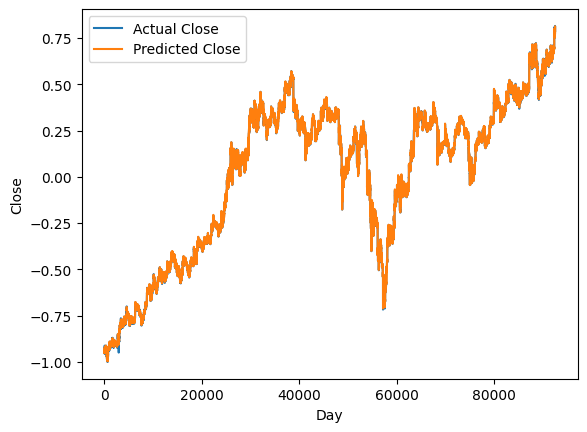

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([30.94289518, 30.97075455, 30.97914222, ..., 55.47531188,
       55.42711505, 55.40453762])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([30.96000024, 30.96000024, 31.04000027, ..., 55.39999982,
       55.39999982, 55.39999982])

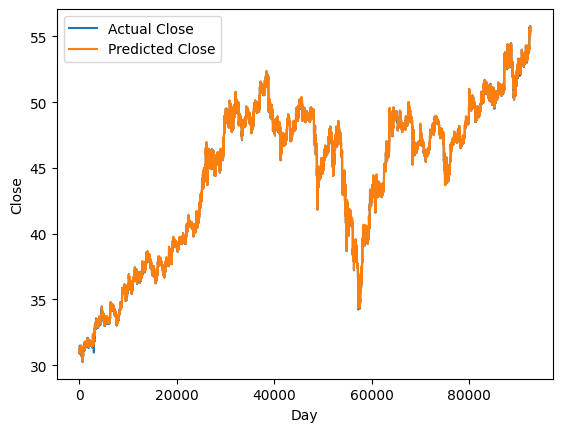

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [27]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([55.39498382, 55.39123043, 55.38990491, ..., 57.94241948,
       57.94820142, 57.91072953])

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([55.39999982, 55.39999982, 55.3000004 , ..., 58.20000032,
       58.10000007, 58.10000007])

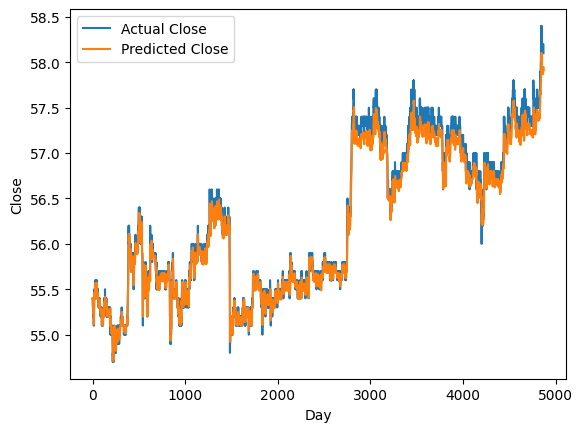

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
